In [1]:
import openslide
from openslide import OpenSlide  
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import os
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import seaborn as sns

# 1. Data Processing

## 1.1. Data Loading

In [2]:
#Reading data
input_path = "../input/mayo-clinic-strip-ai/"
train_df = pd.read_csv(input_path+"train.csv")
test_df = pd.read_csv(input_path+"test.csv")
other_df = pd.read_csv(input_path+"other.csv")

## 1.2. Data Description and visualization 

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_id    754 non-null    object
 1   center_id   754 non-null    int64 
 2   patient_id  754 non-null    object
 3   image_num   754 non-null    int64 
 4   label       754 non-null    object
dtypes: int64(2), object(3)
memory usage: 29.6+ KB


In [4]:
train_df.head(5)

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


(754, 5)
754
Unique Values for: 
image_id      754
center_id      11
patient_id    632
image_num       5
label           2
dtype: int64




[Text(0, 0, '754'),
 Text(0, 0, '11'),
 Text(0, 0, '632'),
 Text(0, 0, '5'),
 Text(0, 0, '2')]

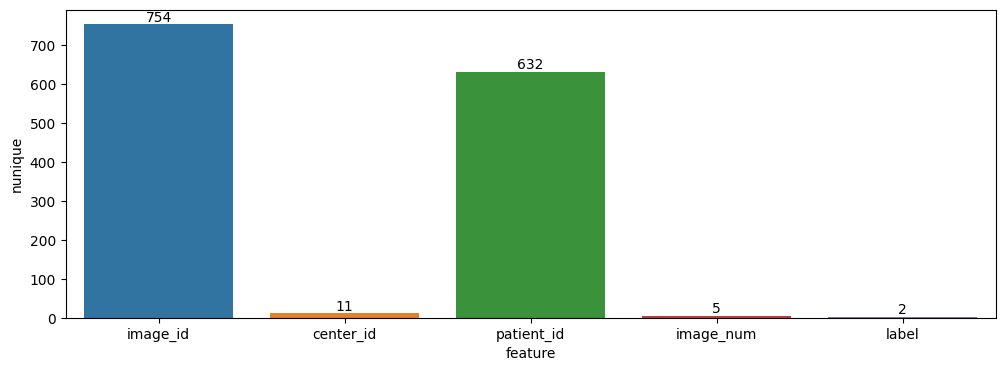

In [5]:
print(train_df.shape)
print(train_df['image_id'].nunique())
print('Unique Values for: ')
print(train_df.nunique())

print('\n')

nu = train_df.nunique().reset_index()
nu.columns = ['feature','nunique']
plt.figure(figsize=(12,4))
ax = sns.barplot(x='feature', y='nunique', data=nu)
ax.bar_label(ax.containers[0])

label
CE     547
LAA    207
Name: count, dtype: int64




<Axes: xlabel='label', ylabel='count'>

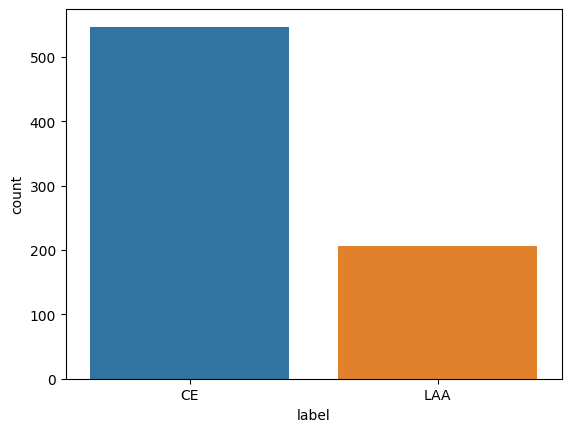

In [6]:
print(train_df['label'].value_counts())
print('\n')
sns.countplot(data=train_df, x='label')

## 1.3. Data Preprocessing

In [7]:
train_df["image_path"] = train_df["image_id"].apply(lambda x: input_path +"train/" + x + ".tif")

In [8]:
train_df.head(5)

,image_id,center_id,patient_id,image_num,label,image_path
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif


## 1.4. Image preprocessing

### 1.4.1. Image viewers

In [9]:
def show_img(img_path, size):
    slide = OpenSlide(img_path) # 512 x 512 or 5120 x 5120
    region = (0, 0)
    image = slide.read_region(region, 0, size)
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.show() 
def show_tiffimg(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
def show_tiff(path):
    tiff_image = tiff.imread(path)
    plt.imshow(tiff_image, cmap='gray')
    plt.axis('off')
    plt.show()    

def show_tiffpath(img_path):
    # Read the image from the file path using tifffile
    img = tiff.imread(img_path)
    
    # Display the image
    plt.imshow(img, cmap='gray')  # Use cmap='gray' if it's a grayscale image; remove it for color
    plt.axis('off')
    plt.show()

### 1.4.2. Image tiling

In [10]:
import math
def is_quality_img(img,dim, ratio):
    return ((np.count_nonzero(img[:,:,0]==np.median(img[:,:,0])) < ratio * dim[0] * dim[1]) 
            and (np.count_nonzero(img[:,:,1]==np.median(img[:,:,1])) < ratio * dim[0] * dim[1])
            and (np.count_nonzero(img[:,:,2]==np.median(img[:,:,2])) < ratio * dim[0] * dim[1]))
    #return True
def preprocess(path, region, size):
    slide = OpenSlide(path)
    image = slide.read_region(region, 0, size).convert('RGB')  # Convert to RGB
    image = np.array(image)
    return image

def image_processing(working_item, new_image_dir=""):
    dim = (256,256,3)
    image_partition = []
    chunk_size = 5000
    min_ratio = 0.8
    new_input = []
    stepx = chunk_size
    stepy = chunk_size
    # Get the image dimensions using OpenSlide
    slide = OpenSlide(working_item["image_path"])
    width, height = slide.dimensions
    print(f"Image dimensions: {height}x{width}")
    if width >= height:
        chunk_size = height
        stepy = chunk_size
        n_step = math.ceil(width/height)
        if n_step > 1:
            stepx=chunk_size-int((n_step*chunk_size - width)/(n_step-1))
        else:
            stepx=chunk_size
    else:
        chunk_size = width
        stepx = chunk_size
        n_step = math.ceil(height/width)
        stepy=chunk_size-int((n_step*chunk_size - height)/(n_step-1))
    if height == 0 or width == 0:
        print("Error: Image dimensions are invalid.")
        return []

    # Process chunks of the image
    for y in range(0, height-chunk_size+1, stepy):
        for x in range(0, width-chunk_size+1, stepx):
            # Extract a chunk using OpenSlide
            print("Process tile partition", x, y)
            img = preprocess(working_item["image_path"], (x, y), (chunk_size, chunk_size))
            dim_prod = chunk_size * chunk_size * 3
            # Check if the image has sufficient information
            if img is not None and img.size > 0 and np.count_nonzero(img) > (1-min_ratio) * dim_prod:
                img = Image.fromarray(img)
                img= img.resize((dim[0], dim[1]), Image.LANCZOS)
                img = np.array(img, dtype=np.uint8)
                show_tiffimg(img) # to be commented
                if is_quality_img(img,dim,0.99):
                    image_partition.append(img)
                else:
                    print("Abort the image as not qualified")
            else:
                print("Number of non-zero",np.count_nonzero(img),"should larger ",(1-min_ratio) * dim_prod)
                print("Number of 255",np.count_nonzero(img==255),"should less than ",min_ratio* dim_prod)

    num_image = len(image_partition)
    for i, img in enumerate(image_partition):
        # Confirm the validity of the image before saving
        if img is None or img.size == 0:
            print(f"Error: Skipping empty or None image at index {i}")
            continue

        # Collect metadata for each image
        new_input.append(
            {
                'image_id': working_item["image_id"] + "_" + str(i),
                'center_id': working_item["center_id"],
                'patient_id': working_item["patient_id"],
                'image_num': num_image,
                'label': working_item["label"],
                'image_path': working_item["image_id"] + "_" + str(i) + ".tif"
            }
        )
        # Ensure the output directory exists
        if not os.path.exists(new_image_dir):
            os.makedirs(new_image_dir)

        # Save the image
        tiff.imwrite(
            new_image_dir + working_item["image_id"] + "_" + str(i) + ".tif",
            img.astype(np.uint8)  # Ensure the image is saved in 8-bit format
        )

    return new_input


#### Process the images, only run once 

In [11]:
output_path = "/kaggle/working/"
input_path = "/kaggle/input/mayo-clinic-processed-image-110-220/"
processed_img_dir = output_path+"processed_image/"
processed_image = [] 
new_input = []
if os.path.exists(input_path+"processed_image.csv"):
    processed_img_dir = input_path+"processed_image/"
    df_processed_image = pd.read_csv(input_path+"processed_image.csv")
    processed_image = df_processed_image['0'].to_list()
    df_sample = train_df[~train_df["image_id"].isin(processed_image)]
    new_input = pd.read_csv(input_path+"new_input.csv")
    new_input = new_input.to_dict('records')
    print("LOADING PROCESSED IMAGE FROM INPUT")
elif os.path.exists(output_path+"processed_image.csv"):
    df_processed_image = pd.read_csv(output_path+"processed_image.csv")
    processed_image = df_processed_image['0'].to_list()
    df_sample = train_df[~train_df["image_id"].isin(processed_image)]
    new_input = pd.read_csv(output_path+"new_input.csv")
    new_input = new_input.to_dict('records')
else:
    df_sample = train_df
if len(df_sample) > 0:
    image_process = True
else:
    image_process = False

LOADING PROCESSED IMAGE FROM INPUT


In [12]:
%%time
import gc
import time
start_time = time.time()
print("Start at", start_time)
while image_process:
    i = 0
    n = min(len(df_sample),100)
    for index, row in df_sample.iloc[:n].iterrows():
        print("Image ",str(index),row["image_id"])
        new_input.extend(image_processing(row,new_image_dir=processed_img_dir))
        processed_image.append(row["image_id"])
        i += 1
        print("Done",100*i/n,"%")
        collected = gc.collect()
        print("Garbage collector: collected", "%d objects." % collected)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print("Checking time at",end_time, ". Run for",elapsed_time,"second")
        if elapsed_time > 36000:
            break
    pd.DataFrame(new_input).to_csv(output_path+"new_input.csv")
    pd.DataFrame(processed_image).to_csv(output_path+"processed_image.csv")
    df_sample = train_df[~train_df["image_id"].isin(processed_image)]
    if len(df_sample) > 0:
        image_process = True
    else:
        image_process = False

Start at 1731308005.6092422
CPU times: user 0 ns, sys: 99 µs, total: 99 µs
Wall time: 105 µs


# 2. Training Data Preparation

In [13]:
if len(train_df) == len(processed_image):
    image_ready = True
else:
    image_ready = False

## 2.1. Load processed images

In [14]:
if image_ready:
    if os.path.exists(input_path+"new_input.csv"):
        train_df = pd.read_csv(input_path+"new_input.csv")
        train_df["image_path"] = train_df["image_id"].apply(lambda x: input_path+"processed_image/" + x + ".tif")
    elif os.path.exists(output_path+"new_input.csv"):
        train_df = pd.read_csv(output_path+"new_input.csv")
        train_df["image_path"] = train_df["image_id"].apply(lambda x: output_path+"processed_image/" + x + ".tif")
    train_df.head(5)

In [15]:
train_df.head(5)

,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,image_id,center_id,patient_id,image_num,label,image_path
0,0,0.0,0.0,0.0,0.0,244aeb_2_0,4,244aeb,2,LAA,/kaggle/input/mayo-clinic-processed-image-110-...
1,1,1.0,1.0,1.0,1.0,244aeb_2_1,4,244aeb,2,LAA,/kaggle/input/mayo-clinic-processed-image-110-...
2,2,2.0,2.0,2.0,2.0,245758_0_0,11,245758,3,LAA,/kaggle/input/mayo-clinic-processed-image-110-...
3,3,3.0,3.0,3.0,3.0,245758_0_1,11,245758,3,LAA,/kaggle/input/mayo-clinic-processed-image-110-...
4,4,4.0,4.0,4.0,4.0,245758_0_2,11,245758,3,LAA,/kaggle/input/mayo-clinic-processed-image-110-...


In [16]:
for index, row in train_df.iterrows():
    if not os.path.exists(row["image_path"]):
        print(row["image_id"],"does not exist",row["image_path"])

## 2.2. Check Data

(1707, 11)
1707
Unique Values for: 
Unnamed: 0.4    1707
Unnamed: 0.3    1640
Unnamed: 0.2    1099
Unnamed: 0.1     488
Unnamed: 0       248
image_id        1707
center_id         11
patient_id       629
image_num          6
label              2
image_path      1707
dtype: int64




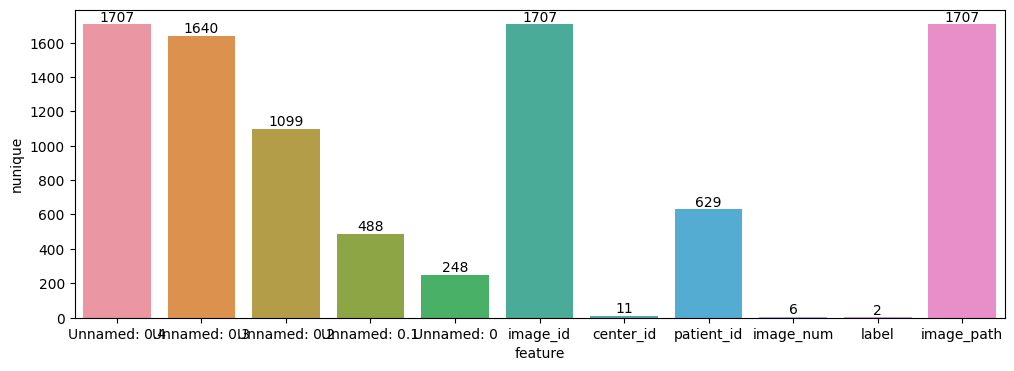

In [17]:
if image_ready:
    print(train_df.shape)
    print(train_df['image_id'].nunique())
    print('Unique Values for: ')
    print(train_df.nunique())
    
    print('\n')
    
    nu = train_df.nunique().reset_index()
    nu.columns = ['feature','nunique']
    plt.figure(figsize=(12,4))
    ax = sns.barplot(x='feature', y='nunique', data=nu)
    ax.bar_label(ax.containers[0])

label
CE     1234
LAA     473
Name: count, dtype: int64




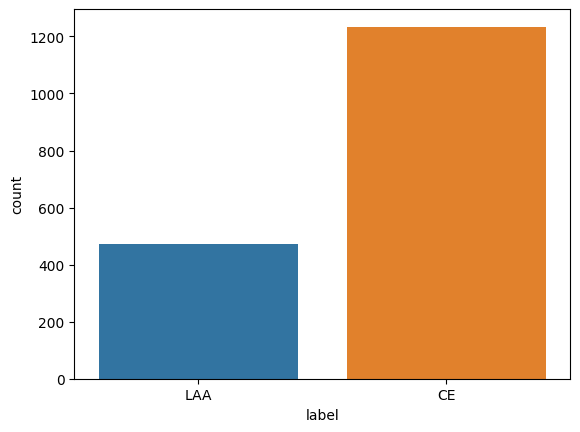

In [18]:
if image_ready:
    print(train_df['label'].value_counts())
    print('\n')
    sns.countplot(data=train_df, x='label')

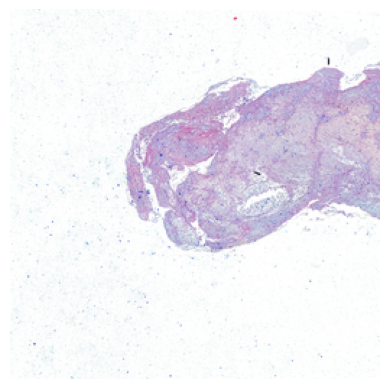

In [19]:
if image_ready:
    show_tiff(train_df.iloc[0]['image_path'])

## 2.3. Prepare Train Data

In [20]:
training_data_ready = False
if image_ready:
    # Include both x and y
    train, val = train_test_split(
        train_df,
        test_size=0.2,       # 20% for validation; adjust as needed
        stratify=train_df['label'],  # Use this to maintain class distribution if 'label' exists
        random_state=42      # For reproducibility
    )
    
    
    print(f"train type: {type(train)}")  
    print(f"val type: {type(val)}")      
    print(train.head())
    IMG_SIZE= 256
    
    image_shape = (IMG_SIZE, IMG_SIZE)
    
    train_datagen=ImageDataGenerator(rescale=1./255,
                               zoom_range=0.2,
                               rotation_range=20,
                               )
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(
                             train,
                             #directory='image_path'
                             x_col = 'image_path',
                             y_col = 'label',
                             target_size=image_shape,
                             class_mode = 'sparse',
                             color_mode = 'rgb',
                             shuffle=True,
                             batch_size=16,
                             seed=19,
                             )
    val_gen = test_datagen.flow_from_dataframe(
                             val,
                             #directory='image_path',
                             x_col = 'image_path',
                             y_col = 'label',
                             target_size=image_shape,
                             class_mode = 'sparse',
                             color_mode = 'rgb',
                             shuffle=True,
                             batch_size=16,
                             seed=19,
                             )
    training_data_ready = True

train type: <class 'pandas.core.frame.DataFrame'>
val type: <class 'pandas.core.frame.DataFrame'>
      Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
434            434         434.0         434.0         434.0         NaN   
1630          1630        1630.0           NaN           NaN         NaN   
1351          1351        1351.0           NaN           NaN         NaN   
1623          1623        1623.0           NaN           NaN         NaN   
598            598         598.0         598.0           NaN         NaN   

        image_id  center_id patient_id  image_num label  \
434   1a2e9e_0_0         11     1a2e9e          2    CE   
1630  f7f1bc_0_0         10     f7f1bc          4    CE   
1351  d13031_0_1          4     d13031          2    CE   
1623  f5ce23_0_0          3     f5ce23          3   LAA   
598   5415fe_0_1         11     5415fe          2    CE   

                                             image_path  
434   /kaggle/input/mayo-clinic-

# 3. Model Training

In [21]:
from keras import models

from tensorflow.keras import layers, Model

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:
model_ready = False

resnet_ready = False
inception_ready = False
efficientnet_ready = False
vgg_ready = False

retrain = False

In [23]:
import warnings

import os

lr = 0.001
epoch_resnet = 20
epoch_inception = 20
epoch_eff = 20
epoch_vgg = 20

# Suppress Python warnings

warnings.filterwarnings("ignore")



# Suppress TensorFlow warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '3' hides all TensorFlow messages



# Re-import TensorFlow to apply changes

tf.get_logger().setLevel('ERROR')


In [24]:
output_path = "/kaggle/working/"
input_path = "/kaggle/input/mayo-clinic-processed-image-110-220/"
resnet = "resnet_model.h5"
inception = "inception_model.h5"
vgg = "vgg16_model.h5"
efficientnet = "efficientnet_model.h5"
if not retrain:
    if os.path.exists(output_path+resnet) or os.path.exists(input_path+resnet):
        resnet_ready = True
    if os.path.exists(output_path+inception) or os.path.exists(input_path+inception):
        inception_ready = True
    if os.path.exists(output_path+efficientnet) or os.path.exists(input_path+efficientnet):
        efficientnet_ready = True
    if os.path.exists(output_path+vgg) or os.path.exists(input_path+vgg):
        vgg_ready = True

## 3.1. Resnet 50 with Batch Normalization and Dropout

### Unfreezed last 2 layers

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint

if training_data_ready and not resnet_ready:
    checkpoint = ModelCheckpoint(
    
        filepath='res_net.keras',  # Path to save the best model
    
        monitor='val_accuracy',   # Metric to monitor (e.g., validation accuracy)
    
        save_best_only=True,      # Save only the best model
    
        mode='max',                # 'max' for accuracy, 'min' for loss
    
        verbose=1                 # Print messages when a checkpoint is saved
    
    )
    
    IMG_SIZE = 256
    
    # Load ResNet50 as the base model
    
    resnet_model = tf.keras.applications.ResNet50(
    
        include_top=False,
    
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    
        pooling='avg',
    
        weights='imagenet'
    
    )
    
    for layer in resnet_model.layers[:-2]:  # Unfreeze the last 2 layers
    
        layer.trainable = False
    
    
    
    # Build the model using the Functional API
    
    inputs = resnet_model.input
    
    x = resnet_model.output
    
    
    
    # Add a dense layer with Batch Normalization and Dropout
    
    x = layers.Dense(256)(x)                    # Dense layer without activation
    
    x = layers.BatchNormalization()(x)           # Batch Normalization before activation
    
    x = layers.Activation('relu')(x)             # Activation after Batch Normalization
    
    x = layers.Dropout(0.5)(x)
    
    
    
    # Final output layer
    
    outputs = layers.Dense(2, activation='softmax')(x)
    
    
    
    # Create the final model
    
    resnet_model = Model(inputs=inputs, outputs=outputs)
    
    # Print the summary
    
    resnet_model.summary()

In [26]:
if training_data_ready and not resnet_ready:
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,mode='min',patience=3, min_lr=1E-5)
    resnet_model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['accuracy']) # Assumes from_logits=False by default
    history = resnet_model.fit(train_gen, epochs=epoch_resnet, validation_data=val_gen, callbacks=[reduce_lr,checkpoint],verbose = 1)
    
    print("Model training complete!")
    resnet_model.save('resnet_model.h5')
    resnet_ready = True

## 3.2. Inception Model

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint

if training_data_ready and not inception_ready:

    checkpoint = ModelCheckpoint(
    
        filepath='inception_model.keras',  # Path to save the best model
    
        monitor='val_accuracy',   # Metric to monitor (e.g., validation accuracy)
    
        save_best_only=True,      # Save only the best model
    
        mode='max',                # 'max' for accuracy, 'min' for loss
    
        verbose=1                 # Print messages when a checkpoint is saved
    
    )
    IMG_SIZE = 256  # Image input size
    
    
    
    # Load InceptionV3 as the base model
    
    inception_model = tf.keras.applications.InceptionV3(
    
        include_top=False,            # Exclude the top layers (fully connected)
    
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    
        pooling='avg',                # Global average pooling for a 1D output
    
        weights='imagenet'            # Load pretrained weights
    
    )
    
    
    
    # Freeze most of the base model layers, but unfreeze the last few
    
    for layer in inception_model.layers[:-2]:  # Unfreeze the last 2 layers
    
        layer.trainable = False
    
    # Build the model using the Functional API
    
    inputs = inception_model.input
    
    x = inception_model.output
    
    
    
    
    
    x = layers.Dense(256)(x)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    
    x = layers.Dropout(0.5)(x)
    
    
    
    # Final output layer for binary classification
    
    outputs = layers.Dense(2, activation='softmax')(x)
    
    
    
    # Create the final model
    
    inception_model = Model(inputs=inputs, outputs=outputs)
    
    
    
    # Print the summary
    
    inception_model.summary()

In [28]:
if training_data_ready and not inception_ready:
    inception_model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['accuracy']) # Assumes from_logits=False by default
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,mode='min',patience=3, min_lr=1E-5)

    history = inception_model.fit(train_gen, epochs=epoch_inception, shuffle=True, validation_data=val_gen, callbacks=[reduce_lr,checkpoint],verbose = 1)
    
    inception_model.save('inception_model.h5')
    
    print("Model training complete!")
    inception_ready = True

## 3.3. EfficientNet Model

In [29]:
if training_data_ready and not efficientnet_ready:
    checkpoint = ModelCheckpoint(
    
        filepath='efficientnet_model.keras',  # Path to save the best model
    
        monitor='val_accuracy',   # Metric to monitor (e.g., validation accuracy)
    
        save_best_only=True,      # Save only the best model
    
        mode='max',                # 'max' for accuracy, 'min' for loss
    
        verbose=1                 # Print messages when a checkpoint is saved
    
    )
    
    IMG_SIZE = 256  # Define the input image size
    
    
    
    # Load EfficientNetB0 as the base model
    
    efficientnet_model = tf.keras.applications.EfficientNetB0(
    
        include_top=False,            # Exclude the top layers (fully connected)
    
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    
        pooling='avg',                # Global average pooling for a 1D output
    
        weights='imagenet'            # Load pretrained weights
    
    )
    
    
    
    # Freeze most of the base model layers, but unfreeze the last few
    
    for layer in efficientnet_model.layers:
    
        layer.trainable = False
    
    
    
    # Build the model using the Functional API
    
    # Use efficientnet_model.input and efficientnet_model.output directly
    
    x = efficientnet_model.output
    
    
    
    # Add a dense layer with Batch Normalization and Dropout
    
    x = layers.Dense(256)(x)                     # Dense layer without activation
    
    x = layers.BatchNormalization()(x)            # Batch Normalization before activation
    
    x = layers.Activation('relu')(x)              # Activation after Batch Normalization
    
    x = layers.Dropout(0.5)(x)
    
    
    
    
    
    # Final output layer for binary classification
    
    outputs = layers.Dense(2, activation='softmax')(x)
    
    
    
    # Create the final model
    
    efficientnet_model = Model(inputs=efficientnet_model.input, outputs=outputs) # Use efficientnet_model.input here
    
    
    
    # Print the model summary
    
    efficientnet_model.summary()

In [30]:
if training_data_ready and not efficientnet_ready:
    efficientnet_model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['accuracy']) # Assumes from_logits=False by default
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,mode='min',patience=3, min_lr=1E-5)
    history = efficientnet_model.fit(train_gen, epochs=epoch_eff, shuffle=True, validation_data=val_gen, callbacks=[reduce_lr,checkpoint],verbose = 1)
    
    print("Model training complete!")
    
    efficientnet_model.save('efficientnet_model.h5')
    efficientnet_ready = True

## 3.4. VGG16 Model

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf

from tensorflow.keras import layers, Model

from tensorflow.keras.applications import VGG16

from tensorflow.keras.optimizers import Adam

if training_data_ready and not vgg_ready:

    checkpoint = ModelCheckpoint(
    
        filepath='vgg16_net.keras',  # Path to save the best model
    
        monitor='val_accuracy',   # Metric to monitor (e.g., validation accuracy)
    
        save_best_only=True,      # Save only the best model
    
        mode='max',                # 'max' for accuracy, 'min' for loss
    
        verbose=1                 # Print messages when a checkpoint is saved
    
    )
    
    # Set image size
    
    IMG_SIZE = 256
    
    
    
    # Load the VGG16 model, excluding the top (fully connected) layers
    
    vgg16_base = VGG16(
    
        include_top=False,              # Exclude the top dense layers
    
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    
        weights='imagenet',             # Use pretrained ImageNet weights
    
        pooling='avg'                   # Apply global average pooling to reduce output dimensions
    
    )
    
    
    
    # Freeze the base model layers (optional, depending on whether you want to fine-tune)
    
    for layer in vgg16_base.layers:
    
        layer.trainable = False
    
    
    
    # Add custom layers on top of VGG16
    
    inputs = vgg16_base.input
    
    x = vgg16_base.output
    
    
    
    # Add dense layers for classification
    
    x = layers.Dense(256, activation='relu')(x)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(0.5)(x)
    
    
    
    x = layers.Dense(128, activation='relu')(x)
    
    x = layers.BatchNormalization()(x)
    
    x = layers.Dropout(0.3)(x)
    
    
    
    # Final output layer (for binary classification, use 2 units; for multi-class, adjust as needed)
    
    outputs = layers.Dense(2, activation='softmax')(x)  # using softmax as we need weighted multi-class logarithmic loss
    
    
    
    # Create the final model
    
    vgg_model = Model(inputs=inputs, outputs=outputs)
    
    
    
    # Compile the model
    
    vgg_model.compile(
    
        optimizer=Adam(learning_rate=0.001),
    
        loss='sparse_categorical_crossentropy',  # Use categorical cross-entropy for multi-class or binary cross-entropy if using sigmoid
    
        metrics=['accuracy']
    
    )
    
    
    
    # Model summary
    
    vgg_model.summary()

In [32]:
if training_data_ready and not vgg_ready:
    vgg_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy']) # Assumes from_logits=False by default
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,mode='min',patience=3, min_lr=1E-5)

    history = vgg_model.fit(train_gen, epochs=epoch_vgg, shuffle=True, validation_data=val_gen, callbacks=[reduce_lr,checkpoint],verbose = 1)
    
    print("Model training complete!")
    
    vgg_model.save('vgg16_model.h5')
    vgg_ready = True

# 4. Prediction

## 4.1. Prepare test data

In [33]:
import math
def is_quality_img(img,dim, ratio):
    return ((np.count_nonzero(img[:,:,0]==np.median(img[:,:,0])) < ratio * dim[0] * dim[1]) 
            and (np.count_nonzero(img[:,:,1]==np.median(img[:,:,1])) < ratio * dim[0] * dim[1])
            and (np.count_nonzero(img[:,:,2]==np.median(img[:,:,2])) < ratio * dim[0] * dim[1]))
    #return True
def preprocess(path, region, size):
    slide = OpenSlide(path)
    image = slide.read_region(region, 0, size).convert('RGB')  # Convert to RGB
    image = np.array(image)
    return image

def test_image_processing(working_item, new_image_dir=""):
    dim = (256,256,3)
    image_partition = []
    chunk_size = 5000
    min_ratio = 0.8
    new_input = []
    stepx = chunk_size
    stepy = chunk_size
    # Get the image dimensions using OpenSlide
    slide = OpenSlide(working_item["image_path"])
    width, height = slide.dimensions
    print(f"Image dimensions: {height}x{width}")
    if width >= height:
        chunk_size = height
        stepy = chunk_size
        n_step = math.ceil(width/height)
        if n_step > 1:
            stepx=chunk_size-int((n_step*chunk_size - width)/(n_step-1))
        else:
            stepx=chunk_size
    else:
        chunk_size = width
        stepx = chunk_size
        n_step = math.ceil(height/width)
        stepy=chunk_size-int((n_step*chunk_size - height)/(n_step-1))
    if height == 0 or width == 0:
        print("Error: Image dimensions are invalid.")
        return []

    # Process chunks of the image
    for y in range(0, height-chunk_size+1, stepy):
        for x in range(0, width-chunk_size+1, stepx):
            # Extract a chunk using OpenSlide
            print("Process tile partition", x, y)
            img = preprocess(working_item["image_path"], (x, y), (chunk_size, chunk_size))
            dim_prod = chunk_size * chunk_size * 3
            # Check if the image has sufficient information
            if img is not None and img.size > 0 and np.count_nonzero(img) > (1-min_ratio) * dim_prod and np.count_nonzero(img == 255) < min_ratio * dim_prod:
                img = Image.fromarray(img)
                img= img.resize((dim[0], dim[1]), Image.LANCZOS)
                img = np.array(img, dtype=np.uint8)
                show_tiffimg(img) # to be commented
                if is_quality_img(img,dim,0.99):
                    image_partition.append(img)
                else:
                    print("Abort the image as not qualified")
            else:
                print("Number of non-zero",np.count_nonzero(img),"should larger ",(1-min_ratio) * dim_prod)
                print("Number of 255",np.count_nonzero(img==255),"should less than ",min_ratio* dim_prod)

    num_image = len(image_partition)
    for i, img in enumerate(image_partition):
        # Confirm the validity of the image before saving
        if img is None or img.size == 0:
            print(f"Error: Skipping empty or None image at index {i}")
            continue

        # Collect metadata for each image
        new_input.append(
            {
                'image_id': working_item["image_id"] + "_" + str(i),
                'center_id': working_item["center_id"],
                'patient_id': working_item["patient_id"],
                'image_num': num_image,
                'parentid': working_item["image_id"],
                'image_path': new_image_dir+working_item["image_id"] + "_" + str(i) + ".tif"
            }
        )
        # Ensure the output directory exists
        if not os.path.exists(new_image_dir):
            os.makedirs(new_image_dir)

        # Save the image
        tiff.imwrite(
            new_image_dir + working_item["image_id"] + "_" + str(i) + ".tif",
            img.astype(np.uint8)  # Ensure the image is saved in 8-bit format
        )

    return new_input, image_partition


In [34]:
input_path = "../input/mayo-clinic-strip-ai/"
test_df = pd.read_csv(input_path+"test.csv")
test_df["image_path"] = test_df["image_id"].apply(lambda x: input_path + "test/"+x + ".tif")

In [35]:
"""
df_sample = test_df
images = []
output_path = "/kaggle/working/"
processed_test_img_dir = output_path+"processed_test_image/"
processed_test_image = [] 
new_test = []

for index, row in df_sample.iterrows():
    print("Image ",str(index),row["image_id"])
    new_test_img,image_partition = test_image_processing(row,new_image_dir=output_path+"processed_test_image/")
    new_test.extend(new_test_img)
    images.extend(image_partition)
    processed_test_image.append(row["image_id"])
    collected = gc.collect()
    print("Garbage collector: collected", "%d objects." % collected)
pd.DataFrame(new_test).to_csv(output_path+"new_test.csv")
pd.DataFrame(processed_test_image).to_csv(output_path+"processed_test_image.csv")
"""

'\ndf_sample = test_df\nimages = []\noutput_path = "/kaggle/working/"\nprocessed_test_img_dir = output_path+"processed_test_image/"\nprocessed_test_image = [] \nnew_test = []\n\nfor index, row in df_sample.iterrows():\n    print("Image ",str(index),row["image_id"])\n    new_test_img,image_partition = test_image_processing(row,new_image_dir=output_path+"processed_test_image/")\n    new_test.extend(new_test_img)\n    images.extend(image_partition)\n    processed_test_image.append(row["image_id"])\n    collected = gc.collect()\n    print("Garbage collector: collected", "%d objects." % collected)\npd.DataFrame(new_test).to_csv(output_path+"new_test.csv")\npd.DataFrame(processed_test_image).to_csv(output_path+"processed_test_image.csv")\n'

In [36]:
output_path = "/kaggle/working/"
input_path = "/kaggle/input/mayo-clinic-processed-image-110-220/"
processed_test_img_dir = output_path+"processed_test_image/"
processed_test_image = [] 
new_test = []
if os.path.exists(input_path+"processed_test_image.csv"):
    processed_test_img_dir = input_path+"processed_test_image/"
    df_processed_test_image = pd.read_csv(input_path+"processed_test_image.csv")
    processed_test_image = df_processed_test_image['0'].to_list()
    df_sample = test_df[~test_df["image_id"].isin(processed_test_image)]
    new_test = pd.read_csv(input_path+"new_test.csv")
    new_test = new_test.to_dict('records')
    print("LOADING PROCESSED IMAGE FROM INPUT")
elif os.path.exists(output_path+"processed_test_image.csv"):
    df_processed_test_image = pd.read_csv(output_path+"processed_test_image.csv")
    processed_test_image = df_processed_test_image['0'].to_list()
    df_sample = test_df[~test_df["image_id"].isin(processed_test_image)]
    new_test = pd.read_csv(output_path+"new_test.csv")
    new_test = new_test.to_dict('records')
else:
    df_sample = test_df
if len(df_sample) > 0:
    test_image_process = True
else:
    test_image_process = False

LOADING PROCESSED IMAGE FROM INPUT


In [37]:
%%time
import gc
images = []
if test_image_process:
    for index, row in df_sample.iterrows():
        print("Image ",str(index),row["image_id"])
        new_test_img,image_partition = test_image_processing(row,new_image_dir=output_path+"processed_test_image/")
        new_test.extend(new_test_img)
        processed_test_image.append(row["image_id"])
        collected = gc.collect()
        print("Garbage collector: collected", "%d objects." % collected)
    pd.DataFrame(new_test).to_csv(output_path+"new_test.csv")
    pd.DataFrame(processed_test_image).to_csv(output_path+"processed_test_image.csv")
    df_sample = test_df[~test_df["image_id"].isin(processed_test_image)]
    if len(df_sample) > 0:
        test_image_process = True
    else:
        test_image_process = False

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.5 µs


## 4.2. Process Test Input

### Load Test Data

In [38]:
if len(test_df) == len(processed_test_image):
    test_image_ready = True
else:
    test_image_ready = False

In [39]:
if test_image_ready:
    if os.path.exists(input_path+"new_test.csv"):
        test_data = pd.read_csv(input_path+"new_test.csv")
        test_img_path = input_path+"processed_test_image/"
    elif os.path.exists(output_path+"new_test.csv"):
        test_data = pd.read_csv(output_path+"new_test.csv")
        test_img_path = output_path+"processed_test_image/"

In [40]:
if test_image_ready:
    test_data["image_path"] = test_data["image_id"].apply(lambda x: test_img_path + x + ".tif")
    test_data.head()
    test_data_ready = True
else:
    test_data_ready = False

### Check Test Data

In [41]:
test_data.head()

,Unnamed: 0,image_id,center_id,patient_id,image_num,parentid,image_path
0,0,006388_0_0,11,006388,2,006388_0,/kaggle/input/mayo-clinic-processed-image-110-...
1,1,006388_0_1,11,006388,2,006388_0,/kaggle/input/mayo-clinic-processed-image-110-...
2,2,006388_0_0,11,006388,2,006388_0,/kaggle/input/mayo-clinic-processed-image-110-...
3,3,006388_0_1,11,006388,2,006388_0,/kaggle/input/mayo-clinic-processed-image-110-...
4,4,008e5c_0_0,11,008e5c,2,008e5c_0,/kaggle/input/mayo-clinic-processed-image-110-...


(12, 7)
10
Unique Values for: 
Unnamed: 0    12
image_id      10
center_id      1
patient_id     4
image_num      2
parentid       4
image_path    10
dtype: int64




[Text(0, 0, '12'),
 Text(0, 0, '10'),
 Text(0, 0, '1'),
 Text(0, 0, '4'),
 Text(0, 0, '2'),
 Text(0, 0, '4'),
 Text(0, 0, '10')]

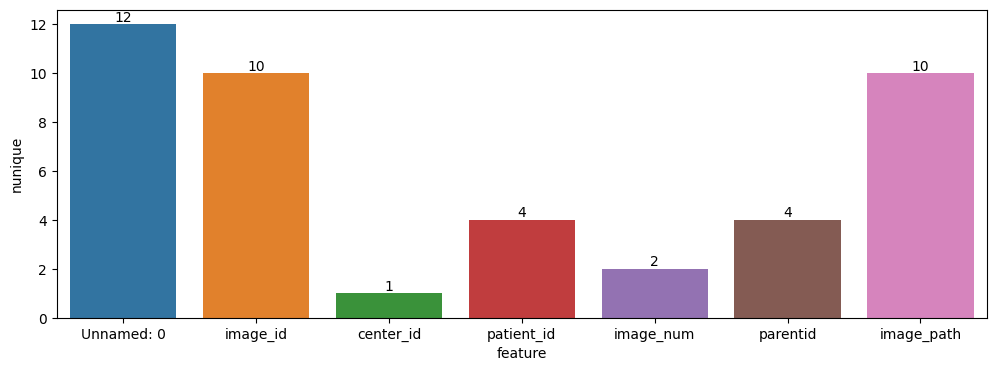

In [42]:
print(test_data.shape)
print(test_data['image_id'].nunique())
print('Unique Values for: ')
print(test_data.nunique())

print('\n')

nu = test_data.nunique().reset_index()
nu.columns = ['feature','nunique']
plt.figure(figsize=(12,4))
ax = sns.barplot(x='feature', y='nunique', data=nu)
ax.bar_label(ax.containers[0])

## 4.3. Process Trainded Models

### Load models

In [43]:
output_path = "/kaggle/working/"
input_path = "/kaggle/input/mayo-clinic-processed-image-110-220/"
resnet = "resnet_model.h5"
inception = "inception_model.h5"
vgg = "vgg16_model.h5"
efficientnet = "efficientnet_model.h5"
if os.path.exists(output_path+resnet):
    resnet_model = tf.keras.models.load_model(output_path+resnet)
    resnet_ready = True
elif os.path.exists(input_path+resnet):
    resnet_model = tf.keras.models.load_model(input_path+resnet)
    resnet_ready = True
    print("GET MODEL FROM INPUT")
if os.path.exists(output_path+inception):
    inception_model = tf.keras.models.load_model(output_path+inception)
    inception_ready = True
elif os.path.exists(input_path+inception):
    inception_model = tf.keras.models.load_model(input_path+inception)
    inception_ready = True
    print("GET MODEL FROM INPUT")
if os.path.exists(output_path+efficientnet):
    efficientnet_model = tf.keras.models.load_model(output_path+efficientnet)
    efficientnet_ready = True
elif os.path.exists(input_path+efficientnet):
    efficientnet_model = tf.keras.models.load_model(input_path+efficientnet)
    efficientnet_ready = True
    print("GET MODEL FROM INPUT")
if os.path.exists(output_path+vgg):
    vgg_model = tf.keras.models.load_model(output_path+vgg)
    vgg_ready = True
elif os.path.exists(input_path+vgg):
    vgg_model = tf.keras.models.load_model(input_path+vgg)
    vgg_ready = True
    print("GET MODEL FROM INPUT")

GET MODEL FROM INPUT
GET MODEL FROM INPUT
GET MODEL FROM INPUT
GET MODEL FROM INPUT


In [44]:
if inception_ready and efficientnet_ready and vgg_ready and resnet_ready:
    model_ready = True

### Check models

In [45]:
if model_ready: 
    resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,796 (91.99 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

 Optimizer params: 2 (12.00 B)

In [46]:
if model_ready: 
    inception_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_4[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 22,328,868 (85.18 MB)

 Trainable params: 525,570 (2.00 MB)

 Non-trainable params: 21,803,296 (83.17 MB)

 Optimizer params: 2 (12.00 B)

In [47]:
if model_ready: 
    efficientnet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,379,047 (16.70 MB)

 Trainable params: 328,962 (1.25 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

 Optimizer params: 2 (12.00 B)

In [48]:
if model_ready: 
    vgg_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,89

 Total params: 14,880,708 (56.77 MB)

 Trainable params: 165,250 (645.51 KB)

 Non-trainable params: 14,715,456 (56.14 MB)

 Optimizer params: 2 (12.00 B)

## 4.4. Prediction

In [49]:
import gc
def predict_patient(patient_id, models):
    chunk_images = []
    predict = []
    for img_path in test_data[test_data["patient_id"] == patient_id]["image_path"]:
        print(img_path)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))  # Adjust target_size as needed
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0 
        img_array = tf.expand_dims(img_array, 0)
        chunk_images.append(img_array)
    chunk_images_tensor = tf.concat(chunk_images, axis=0)
    for model in models: 
        predict.append(model.predict(chunk_images_tensor))
    return predict

### Prediction for each person with each model

In [50]:
import gc
# Load the saved models and uncomment when model is availble 

# Models and their weight in 
if model_ready and test_data_ready:
    models = [resnet_model,inception_model,efficientnet_model,vgg_model]
    
    patient_ids = test_data['patient_id'].unique()
    
    patient_predictions = {}
    
    for patient_id in patient_ids:
        # Get predictions from models
        patient_predictions[patient_id] = predict_patient(patient_id, models)
        collected = gc.collect()
        print("Garbage collector: collected", "%d objects." % collected)
    prediction = True

/kaggle/input/mayo-clinic-processed-image-110-220/processed_test_image/006388_0_0.tif
/kaggle/input/mayo-clinic-processed-image-110-220/processed_test_image/006388_0_1.tif
/kaggle/input/mayo-clinic-processed-image-110-220/processed_test_image/006388_0_0.tif
/kaggle/input/mayo-clinic-processed-image-110-220/processed_test_image/006388_0_1.tif


I0000 00:00:1731308025.844219      70 service.cc:145] XLA service 0x7e3e7c003880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731308025.844294      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


I0000 00:00:1731308028.775284      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Garbage collector: collected 1438 objects.
/kaggle/input/mayo-clinic-processed-image-110-220/processed_test_image/008e5c_0_0.tif
/kaggle/input/mayo-clinic-processed-image-110-220/processed_test_image/008e5c_0_1.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Garbage collector: collected 1396 objects.
/kaggle/input/mayo-clinic-processed-image-110-220/processed_test_image/00c058_0_0.tif
/kaggle/input/mayo-clinic-processed-image-110-220/processed_test_image/00c058_0_1.tif
/kaggle/input/mayo-clinic-processed-image-110-220/processed_test_image/00c058_0_2.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Garbage collector: collected 1385 objects.
/kaggle/input/mayo-clinic-processed-image-110

### Ensemble Prediction result

In [51]:
import numpy
if prediction:
    weights = [0.2,0.3,0.2,0.3]
    patient_probs = {}
    for patient_id in patient_ids:
    
        predict = patient_predictions[patient_id]
    
        ensemble_preds = 0
        for a, w in zip(predict,weights):
            ensemble_preds += a*w
    
        # Average probabilities for the patient
        patient_prob = np.mean(ensemble_preds, axis=0)
        patient_probs[patient_id] = patient_prob

In [52]:
patient_probs

{'006388': array([0.7212025 , 0.27879754], dtype=float32),
 '008e5c': array([0.86597586, 0.1340242 ], dtype=float32),
 '00c058': array([0.59942836, 0.40057167], dtype=float32),
 '01adc5': array([0.5318405 , 0.46815956], dtype=float32)}

In [53]:
# Create submission DataFrame
if prediction:
    submission_data = []
    
    for patient_id, probs in patient_probs.items():
        submission_data.append([patient_id, probs[0], probs[1]])  # Assuming [CE, LAA] order
    
    submission_df = pd.DataFrame(submission_data, columns=['patient_id', 'CE', 'LAA'])

In [54]:
submission_df

,patient_id,CE,LAA
0,006388,0.721202,0.278798
1,008e5c,0.865976,0.134024
2,00c058,0.599428,0.400572
3,01adc5,0.531841,0.468160


In [55]:
submission_df.to_csv('submission.csv', index = False)
!head submission.csv

patient_id,CE,LAA
006388,0.7212025,0.27879754
008e5c,0.86597586,0.1340242
00c058,0.59942836,0.40057167
01adc5,0.5318405,0.46815956
